In [1]:
%pip install keras_tuner

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras_tuner.tuners import RandomSearch
import matplotlib.pyplot as plt

In [5]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

In [6]:
# Step 3: Defining the class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [9]:
def build_model(hp):
    model = models.Sequential()
    # Tune the number of Convolutional Layers (1, 2 or 3)
    for i in range(hp.Int('conv_layers', 1, 3)):
        if i == 0:
            model.add(layers.Conv2D(
                filters = hp.Int('filters_' + str(i), min_value=32, max_value=128, step=16),
                kernel_size = (3, 3),
                activation = 'relu',
                input_shape = (32, 32, 3)
        ))
        else:
            model.add(layers.Conv2D(
                filters = hp.Int('filters_' + str(i), min_value=32, max_value=128, step=16),
                kernel_size = (3, 3),
                activation = 'relu',
                padding = 'same'))
            
            model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Flatten())

    # Tune the number of Dense Layers (1,2 or 3)
    for i in range(hp.Int('dense_layers', 1, 3)):
        model.add(layers.Dense(
            units = hp.Int('units_' + str(i), min_value=32, max_value=128, step=16), activation = 'relu'))
        # Tune the dropout rate
        model.add(layers.Dropout(rate=hp.Float('dropout_' + str(i), min_value=0.0, max_value=0.5, step=0.1)))

    # The last dense layer with 10 output units (for 10 classes of CIFAR-10 dataset)
    model.add(layers.Dense(10))
    # Choose an optimizer and learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))
    model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    return model

In [10]:
# Step 5: Define the Tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='cifar10_tunning'
)

# Step 6: Perform the Hyperparameter search
tuner.search(train_images, train_labels, epochs=5, validation_data=(test_images, test_labels))
# Step 7: Get the best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# Step 8: Build the model with the best Hyperparameters and train it
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

Trial 10 Complete [00h 19m 37s]
val_accuracy: 0.10000000149011612

Best val_accuracy So Far: 0.7005000114440918
Total elapsed time: 05h 07m 53s
Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 271s 170ms/step - accuracy: 0.2550 - loss: 1.9742 - val_accuracy: 0.5509 - val_loss: 1.2570
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 250s 160ms/step - accuracy: 0.5145 - loss: 1.3556 - val_accuracy: 0.6371 - val_loss: 1.0383
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 266s 170ms/step - accuracy: 0.6009 - loss: 1.1383 - val_accuracy: 0.6607 - val_loss: 0.9714
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 274s 175ms/step - accuracy: 0.6505 - loss: 1.0132 - val_accuracy: 0.6921 - val_loss: 0.8837
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 258s 165ms/step - accuracy: 0.6769 - loss: 0.9413 - val_accuracy: 0.7057 - val_loss: 0.8588
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 266s 170ms/step - accuracy: 0.7054 - loss: 0.8598 - val_accuracy: 0.7128 - val_loss: 0.8516
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 258s 165ms

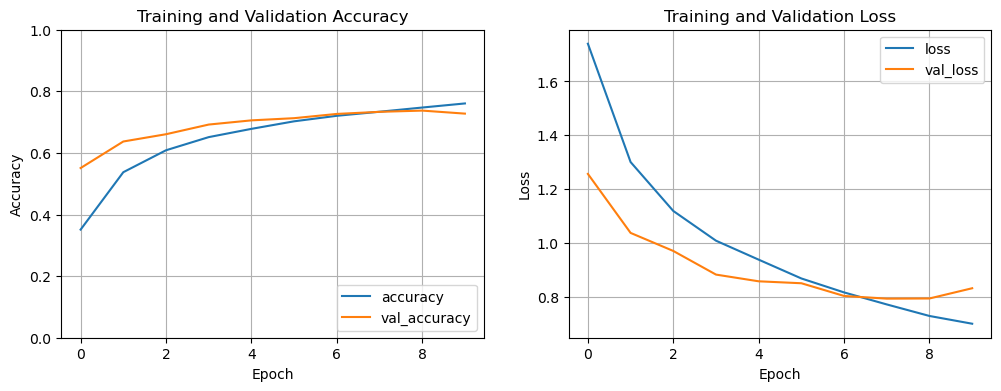

In [11]:
# Step 9: Plotting training & validation accuracy and loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid()
plt.show()